In [1]:
%matplotlib inline

In [2]:
import time
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from dataload import lang, localdata
from tagger.charbilstm import CharBiLSTM
from etc.customUtil import showGraph, showParallel
from etc import defaultsetting as ds

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
tag_PAD = ds.TOKKEN_PAD_IDX
tag_UNK = ds.TOKKEN_UNK_IDX

datasets, engdict, posdict = localdata.load_kor_ner(device, strmode=True) # , charmode=True)
num_words = engdict.n_words
num_chars = engdict.n_chars
num_poss = posdict.n_words
print(num_words)
print(num_chars)
print(num_poss)
# print(MAX_LENGTH)
print(engdict.max_len_char)
print(engdict.max_len_word)
print(posdict.max_len_char)
print(posdict.max_len_word)

print(len(datasets['dev'].y_data))
print(len(datasets['test'].y_data))
print(len(datasets['train'].y_data))

14096
1446
23
13
245
4
245
250
500
4250


In [5]:
def iteration(samples, optimizer, criterion):
    x_train, y_train = samples
        
    optimizer.zero_grad()

    o = model(engdict, device, x_train)
    o = o.view(-1,o.size(-1))
    t = y_train.view(-1)

    loss = criterion(o, t)
    loss.backward()
    optimizer.step()

    return loss.item()

In [6]:
def epoch(model, optimizer, criterion, dataloader):
    model.train()
    list_loss = []
    for batch_idx, samples in enumerate(dataloader):
        loss = iteration(samples, optimizer, criterion)
        list_loss.append(loss)
    return list_loss

In [7]:
def evaluate(model, criterion, dataloader):
    model.eval()
    total_loss = 0
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples

        o = model(engdict, device, x_train)
        o = o.view(-1,o.size(-1))
        t = y_train.view(-1)

        total_loss += criterion(o, t).item()

        # if batch_idx % 100 == 0:
            # print(batch_idx, loss.item())
            
    # print(batch_idx, loss.item())
    return total_loss / (batch_idx+1)

In [8]:
def scores(model, dataset, batch_size):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    total_samples = len(dataset)
    cnt_corr_samples = 0
    total_words = 0
    cnt_corr_words = 0
    c = posdict.n_words
    table = torch.zeros(c,c)
    
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples
        
        o = model(engdict, device, x_train)
        t = y_train.view(-1)

        __tagged, tagged = torch.max(o, dim=-1)
        
        for i in range(y_train.size(0)):
            l = y_train[i].tolist()
            if tag_PAD in l:
                seq_len = l.index(tag_PAD)
            else:
                seq_len = len(l)
            
            _y = y_train[i,:seq_len]
            _p = tagged[i,:seq_len]
            d = _p!=_y
            cnt_wrong = _p[d].size()[0]
            
            # score1_acc_sample
            if cnt_wrong == 0:
                cnt_corr_samples +=1
                
            # score2_acc_word
            total_words += seq_len
            cnt_corr_words += seq_len - cnt_wrong
            
            # score3_f1
            for j in range(seq_len):
                table[_y[j],_p[j]] += 1

    tp = torch.tensor([table[i,i] for i in range(c)])[2:]
    d0sum = table[2:,2:].sum(dim=0)
    d1sum = table[2:,2:].sum(dim=1)
    allsum = d1sum.sum()
    
    pr = tp / d0sum
    temp = pr != pr
    pr[temp] = 0
    
    re = tp / d1sum
    temp = re != re
    re[temp] = 0
    
    f1 = 2 * pr * re / (pr + re)
    temp = f1 != f1
    f1[temp] = 0
    
    avg_f1 = (f1 * d1sum).sum() / allsum
  
    return (cnt_corr_samples / total_samples,
            cnt_corr_words / total_words,
            avg_f1.item())

In [9]:
def train_losses_scores(model, optimizer, criterion, datasets, batch_size, num_epoch):

    dict_losses={'train': [],
                 'dev': [],
                 'test': []
                }
    
    dict_scores={'train': [[],[],[]],
                 'dev': [[],[],[]],
                 'test': [[],[],[]]
                }
    best_dev_f1 = 0.0
    for epoch_i in range(1,num_epoch+1):
        dataloader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True)
        dataloader_dev = DataLoader(datasets['dev'], batch_size=batch_size, shuffle=True)
        dataloader_test = DataLoader(datasets['test'], batch_size=batch_size, shuffle=True)
        print(f'\r{epoch_i}', end='')
        temp = epoch(model, optimizer, criterion, dataloader)
        dict_losses['train'].extend(temp)
        dict_losses['dev'].append(evaluate(model, criterion, dataloader_dev))
        dict_losses['test'].append(evaluate(model, criterion, dataloader_test))

        s_train = scores(model, datasets['train'], 100)
        s_dev = scores(model, datasets['dev'], 100)
        s_test = scores(model, datasets['test'], 100)
        
        dict_scores['train'][0].append(s_train[0])
        dict_scores['train'][1].append(s_train[1])
        dict_scores['train'][2].append(s_train[2])
        dict_scores['dev'][0].append(s_dev[0])
        dict_scores['dev'][1].append(s_dev[1])
        dict_scores['dev'][2].append(s_dev[2])
        dict_scores['test'][0].append(s_test[0])
        dict_scores['test'][1].append(s_test[1])
        dict_scores['test'][2].append(s_test[2])
        
        if s_dev[2] > best_dev_f1:
            print(f' epoch Dev F1 score: {best_dev_f1:.6} -> {s_dev[2]:.6}')
            best_dev_f1 = s_dev[2]
            torch.save(model, 'best_char_bilstm_pos.pt')
    print()
    return dict_losses, dict_scores

In [10]:
def pos_tagging(model, input_seq):
    model.eval()
    o = model(engdict, device, input_seq)
    __tagged, tagged = torch.max(o, dim=-1)
    return tagged

In [11]:
def calc(model, input_seq, target_seq=None):
    # input_seq = engdict.tensorFromSentence(input_seq, device)
    # input_list = engdict.sentenceFromIndexes(input_seq.tolist())
    input_list = input_seq.split()

    # print(input_list)
    # print(sentenceFromIndexes(posdict, target_seq.tolist()))
    output_list = posdict.sentenceFromIndexes(pos_tagging(model, [input_seq]).view(-1).tolist())
    
    target_list = None
    if target_seq is not None:
        target_list = posdict.sentenceFromIndexes(target_seq.tolist())

#     print(output_list)
    showParallel(input_list, output_list, target_list)

In [12]:
# embedding_dim = 100
char_dim = 10
word_dim = 50
size_hidden = 50
num_layers = 1
size_out = num_poss
size_batch = 100
# criterion  = nn.CrossEntropyLoss().to(device)
criterion  = nn.CrossEntropyLoss(ignore_index=tag_PAD).to(device)

In [13]:
model = CharBiLSTM(num_chars, num_words, char_dim, word_dim, size_hidden, size_out, num_layers, tag_PAD).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epoch = 60
st = time.time()
dict_losses, dict_scores = train_losses_scores(model, optimizer, criterion, datasets, size_batch, num_epoch)
print(f'\t{time.time()-st:5}')

1 epoch Dev F1 score: 0.0 -> 0.8032
2 epoch Dev F1 score: 0.8032 -> 0.849671
3 epoch Dev F1 score: 0.849671 -> 0.87616
4 epoch Dev F1 score: 0.87616 -> 0.923926
5 epoch Dev F1 score: 0.923926 -> 0.933615
6 epoch Dev F1 score: 0.933615 -> 0.946533
7 epoch Dev F1 score: 0.946533 -> 0.954033
8 epoch Dev F1 score: 0.954033 -> 0.955844
9 epoch Dev F1 score: 0.955844 -> 0.958537
10 epoch Dev F1 score: 0.958537 -> 0.960778
12 epoch Dev F1 score: 0.960778 -> 0.961282
14 epoch Dev F1 score: 0.961282 -> 0.961848
16 epoch Dev F1 score: 0.961848 -> 0.963491
17 epoch Dev F1 score: 0.963491 -> 0.965081
45 epoch Dev F1 score: 0.965081 -> 0.965407
53 epoch Dev F1 score: 0.965407 -> 0.96544
57 epoch Dev F1 score: 0.96544 -> 0.965558
60
	1978.3093795776367


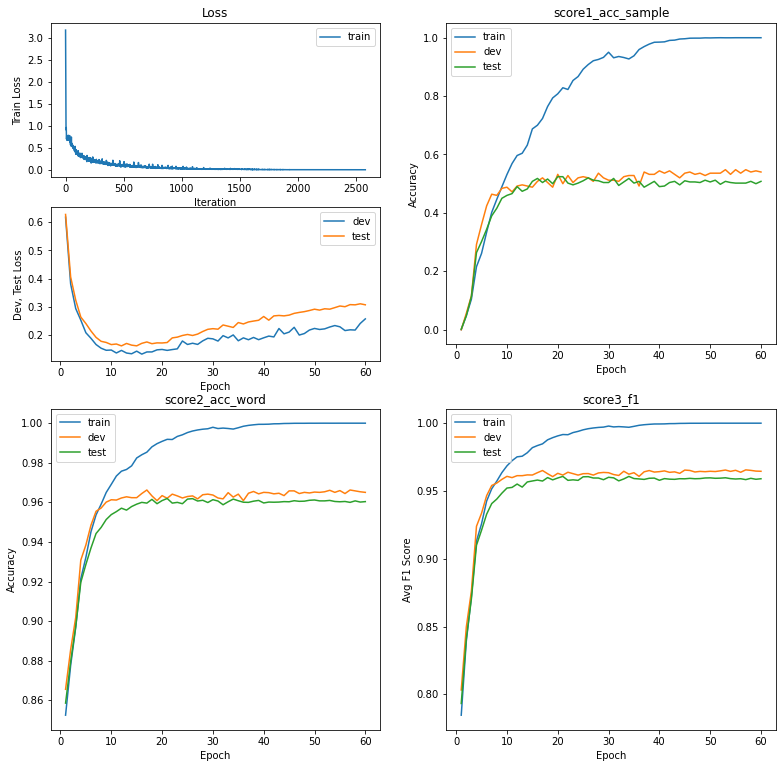

In [14]:
showGraph(dict_losses, dict_scores)

In [15]:
score_type=2
for i in range(len(dict_scores["train"][score_type])):
    print(f'{dict_scores["train"][score_type][i]:<.5}   {dict_scores["dev"][score_type][i]:<05.4}   {dict_scores["test"][score_type][i]:.5}')

0.78461   0.8032   0.79326
0.8392   0.8497   0.84097
0.87208   0.8762   0.87039
0.91305   0.9239   0.90995
0.92583   0.9336   0.92107
0.94256   0.9465   0.93288
0.95161   0.954   0.94069
0.95726   0.9558   0.94402
0.96353   0.9585   0.94837
0.96851   0.9608   0.95215
0.97232   0.9598   0.95262
0.97517   0.9613   0.9551
0.97563   0.9613   0.95284
0.97818   0.9618   0.95664
0.98194   0.9618   0.95736
0.98348   0.9635   0.95804
0.98475   0.9651   0.95732
0.98772   0.9627   0.95986
0.98932   0.9606   0.95819
0.99062   0.963   0.95957
0.99162   0.9617   0.96074
0.99149   0.9638   0.95783
0.99306   0.9628   0.95822
0.99395   0.9617   0.95783
0.99511   0.9627   0.96045
0.99592   0.9628   0.96054
0.99646   0.9617   0.95956
0.99687   0.9633   0.95954
0.99709   0.9637   0.9583
0.99787   0.9635   0.96009
0.99723   0.9621   0.95967
0.99747   0.9615   0.95745
0.99725   0.9645   0.95887
0.99697   0.9624   0.96073
0.99766   0.9635   0.95914
0.99842   0.9608   0.95887
0.99886   0.9641   0.95852
0.9991

In [25]:
testset = datasets['test']
for ii in range(len(testset)):
    i = 16
    input_seq = testset.x_data[i]
    target_seq = testset.y_data[i]
    calc(model, input_seq, target_seq)
    break
#     print(target_seq)

words               tags    targets
맨시티                 B-PS    B-OG
의                   O       O
스벤                  O       B-PS
예란                  O       I-PS
에릭손                 B-PS    I-PS
감독                  O       O
은                   O       O
8                   B-DT    B-DT
일                   I-DT    I-DT
현지                  O       O
언론                  O       O
과                   O       O
의                   O       O
인터뷰                 O       O
에서                  O       O
호나우지뉴               B-PS    B-PS
영입                  O       O
가능                  O       O
성                   O       O
에                   O       O
대해                  O       O
"                   O       O
호나우지뉴               B-PS    B-PS
의                   O       O
영입설                 O       O
은                   O       O
처음                  O       O
들                   O       O
어                   O       O
보                   O       O
는                   O       O
이야기       

In [17]:
# sen = 'I am your father .'
# # in_sen = torch.tensor(engdict.indexesFromSentence(sen), device=device)

# # sen2 = [4609,   25,   35,  116, 4610, 1562,   74,  115, 4611,   49, 4612, 1456,
# #         4613,  224,  691,    6, 4614,   76,   30, 1742, 4615,  308,  107, 4614,
# #          116, 4616, 4617,   17]
# # in_sen = torch.tensor(sen2, device=device)

# calc(model, sen)

words               tags
I                   O
am                  O
your                O
father              O
.                   O


In [18]:
best_model = torch.load('best_char_bilstm_pos.pt')
s_dev = scores(best_model, datasets['dev'], 100)
s_test = scores(best_model, datasets['test'], 100)
print(s_dev)
print(s_test)

(0.548, 0.9662434652725915, 0.9655578136444092)
(0.502, 0.9599939727265878, 0.958366870880127)
